In [1]:
#set path to folder above this
import sys
sys.path.append("..")
import numpy as np
from torch.distributions.categorical import Categorical
from utils import live_plot
from environments.ElevatorEnvironment import ElevatorEnvironment
from sentence_transformers import SentenceTransformer

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import tqdm
import gym
import pickle

c:\Users\ianch\miniconda3\envs\aiplanning\Lib\site-packages\pyRDDLGym\Elevator.py:8: UserWarning: cv2 is not installed: save_as_mp4 option will be disabled.
  from pyRDDLGym.Visualizer.MovieGenerator import MovieGenerator
c:\Users\ianch\miniconda3\envs\aiplanning\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
#auto reload
%load_ext autoreload
%autoreload 2
#enable live plot
%matplotlib inline

## NLP Policy Network

### Define Policy Network

1. `all-mpnet-base-v2` as backbone to transform text state into latent state
2. self-attention transformer layers to relevant attention information (since the embedding is not being trained)
3. FFC to get q-values vector.

In [5]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    """Initialize the weights and biases of a layer.

    Args:
        layer (nn.Module): The layer to initialize.
        std (float): Standard deviation for orthogonal initialization.
        bias_const (float): Constant value for bias initialization.

    Returns:
        nn.Module: The initialized layer.
    """
    torch.nn.init.orthogonal_(layer.weight, std)  # Orthogonal initialization
    torch.nn.init.constant_(layer.bias, bias_const)  # Constant bias
    return layer

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from transformers import AutoTokenizer, AutoModel
from typing import List

class TransformerNetwork(nn.Module):
    def __init__(self, 
                 embedding_dim=768,
                 output_dim=4,
                 num_transformer_layers=1,
                 fc_hidden_dims=[512, 256],
                 fc_output_std=0.01
                 ):
        super(TransformerNetwork, self).__init__()
                
        self.embedding_dim = embedding_dim
        
        # Transformer encoder layer (self-attention)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.embedding_dim, nhead=8, dim_feedforward=2048
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)
        
        # Configurable fully connected layers for Q-values
        fc_layers = []
        input_dim = self.embedding_dim
        for hidden_dim in fc_hidden_dims:
            fc_layers.append(nn.Linear(input_dim, hidden_dim))
            fc_layers.append(nn.ReLU())
            input_dim = hidden_dim
        fc_layers.append(nn.Linear(input_dim, output_dim))  # Output layer for Q-values
        self.fc = nn.Sequential(*fc_layers)
    
    def forward(self, embeddings):
        assert isinstance(embeddings, torch.Tensor), f"Expected input type torch.Tensor but got {type(embeddings)}"
        assert embeddings.shape[-1] == self.embedding_dim, f"Expected input shape [batch_size, seq_len, {self.embedding_dim}] but got {embeddings.shape}"
        
        # Pass embeddings through the transformer encoder layer
        transformer_output = self.transformer_encoder(embeddings)  # Shape: [batch_size, seq_len, embedding_dim]
        
        # Average the transformer output across the sequence dimension
        pooled_output = transformer_output.mean(dim=1)
        
        # Output Q-values
        q_values = self.fc(pooled_output)  # Shape: [batch_size, num_actions]
        return q_values
        
class NLPolicyNetwork(nn.Module):
    def __init__(self, 
                 encoder_name='sentence-transformers/all-mpnet-base-v2',
                 action_space_n=4,
                 num_transformer_layers=1,
                 fc_hidden_dims=[512, 256],
                 device='cuda'
                 ):
        super(NLPolicyNetwork, self).__init__()
                
        self.tokenizer = AutoTokenizer.from_pretrained(encoder_name)
        self.encode_model = AutoModel.from_pretrained(encoder_name).to(device).eval()
        self.device = device   
        self.embedding_dim = self.encode_model.config.hidden_size
        
        self.DQN = TransformerNetwork(
            embedding_dim=self.embedding_dim,
            output_dim=action_space_n,
            num_transformer_layers=num_transformer_layers,
            fc_hidden_dims=fc_hidden_dims
        ).to(device)
        
    def forward(self, states: List[str]):
        # print(type(states))
        states = self.tokenizer(states, padding=True, truncation=True, return_tensors="pt") # Shape: [batch_size, seq_len, embedding_dim]
        states = {k: v.to(self.device) for k, v in states.items()}
        
        # Pass state through the encoder
        with torch.no_grad():
            state_embeddings = self.encode_model(**states).last_hidden_state  # Shape: [batch_size, seq_len, embedding_dim]
        
        # Pass embeddings through the DQN
        q_values = self.DQN(state_embeddings)
        
        return q_values
    

### Generate pre-training data using expert agent

In [12]:
env = ElevatorEnvironment()

c:\Users\ianch\miniconda3\envs\aiplanning\Lib\site-packages\pyRDDLGym\Examples c:\Users\ianch\miniconda3\envs\aiplanning\Lib\site-packages\pyRDDLGym\Examples\manifest.csv
Available example environment(s):
CartPole_continuous -> A simple continuous state-action MDP for the classical cart-pole system by Rich Sutton, with actions that describe the continuous force applied to the cart.
CartPole_discrete -> A simple continuous state MDP for the classical cart-pole system by Rich Sutton, with discrete actions that apply a constant force on either the left or right side of the cart.
Elevators -> The Elevator domain models evening rush hours when people from different floors in a building want to go down to the bottom floor using elevators.
HVAC -> Multi-zone and multi-heater HVAC control problem
MarsRover -> Multi Rover Navigation, where a group of agent needs to harvest mineral.
MountainCar -> A simple continuous MDP for the classical mountain car control problem.
NewLanguage -> Example with

generate trajectories

In [ ]:

# get expert agent
from agents.elevator_expert import ElevatorExpertPolicyAgent

agent = ElevatorExpertPolicyAgent()

# generate expert trajectories
num_trajectories = 100000

trajectories = []

state, _ = env.reset()

num_episodes = 0

for _ in tqdm.tqdm(range(num_trajectories)):
    state_text = env.state_to_text(state)
    action = agent.act(state)
    next_state, reward, done, _, _ = env.step(action)
    next_state_text = env.state_to_text(next_state)
    
    trajectories.append((num_episodes, state_text, action, reward, next_state_text, done))
    
    if done:
        state, _ = env.reset()
        num_episodes += 1
    else:
        state = next_state
        
# save trajectories
import pickle

with open("trajectories/expert_trajectories.pkl", "wb") as f:
    pickle.dump(trajectories, f)    

100%|██████████| 100000/100000 [03:47<00:00, 440.12it/s]


In [ ]:
# NOT USED BECAUSE THE FILE SAVE IS TOO BIG, CHANGE TO GETTING EMBEDDINGS ON THE FLY

# # load trajectories
# trajectories = pickle.load(open("trajectories/expert_trajectories.pkl", "rb"))

# from transformers import AutoTokenizer, AutoModel
# import torch
# from torch.utils.data import DataLoader, Dataset

# # Initialize model and tokenizer
# model_name = 'sentence-transformers/all-mpnet-base-v2'
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModel.from_pretrained(model_name).to("cuda")

# # Custom dataset class
# class TrajectoryTextDataset(Dataset):
#     def __init__(self, texts):
#         self.texts = texts

#     def __len__(self):
#         return len(self.texts)

#     def __getitem__(self, idx):
#         return self.texts[idx]

# # Custom collate function for padding
# def collate_fn(batch):
#     # Tokenize with padding and return tensors
#     episode_id, state, action, reward, next_state, done = zip(*batch)
    
#     state = tokenizer(list(state), padding=True, truncation=True, return_tensors="pt")
#     next_state = tokenizer(list(next_state), padding=True, truncation=True, return_tensors="pt")
    
#     return episode_id, state, action, reward, next_state, done
    

# # Load data
# dataset = TrajectoryTextDataset([t for t in trajectories])
# data_loader = DataLoader(dataset, batch_size=64, collate_fn=collate_fn)

# # Processing loop
# # all_embeddings = []
# model.eval()  # Set model to evaluation mode for efficiency
# with torch.no_grad():  # Disable gradient computation for faster inference
#     file_id = 0
#     for batch in tqdm.tqdm(data_loader):
#         episode_id, state, action, reward, next_state, done = batch
#         state, next_state = state.to("cuda"), next_state.to("cuda")
#         # Forward pass to get token-level embeddings
#         state_tensor = model(**state).last_hidden_state.cpu()  # Shape: [batch_size, seq_len, embedding_dim]
#         next_state_tensor = model(**next_state).last_hidden_state.cpu()
#         # transform action to tensor
#         action_tensor = torch.tensor(action, dtype=torch.long).cpu()
#         action_tensor = F.one_hot(action_tensor, num_classes=4).float() # shape: [batch_size, num_actions]
#         # transform reward to tensor
#         reward_tensor = torch.tensor(reward).float().cpu().unsqueeze(1)  # shape: [batch_size, 1]
#         # transform done to tensor
#         done_tensor = torch.tensor(done).float().cpu().unsqueeze(1)  # shape: [batch_size, 1]

#         # Save as batch to dataset/elevator_expert_state_action/ folder
#         torch.save(state_tensor, f"dataset/elevator_expert/state/s_{file_id:04d}.pt")
#         torch.save(action_tensor, f"dataset/elevator_expert/action/a_{file_id:04d}.pt")
#         torch.save(reward_tensor, f"dataset/elevator_expert/reward/r_{file_id:04d}.pt")
#         torch.save(next_state_tensor, f"dataset/elevator_expert/next_state/ns_{file_id:04d}.pt")
#         torch.save(done_tensor, f"dataset/elevator_expert/done/n_{file_id:04d}.pt")
        
#         file_id += 1
        

100%|██████████| 1563/1563 [05:34<00:00,  4.68it/s]


### Train NLPolicy - DAgger Style

In [ ]:
# load trajectories
trajectories = pickle.load(open("trajectories/expert_trajectories.pkl", "rb"))

from transformers import AutoTokenizer, AutoModel
import torch
from torch.utils.data import DataLoader, Dataset

states = [t[1] for t in trajectories]
actions = [t[2] for t in trajectories]

# Custom dataset class
class StateActionDataset(Dataset):
    def __init__(self, states, actions):
        self.states = states
        self.actions = actions
        
        assert len(self.states) == len(self.actions), "States and actions must have the same length"

    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        return self.states[idx], self.actions[idx]

# Custom collate function for padding
def collate_fn(batch):
    # Tokenize with padding and return tensors
    states, actions = zip(*batch)
    
    # states = tokenizer(list(states), padding=True, truncation=True, return_tensors="pt") # Shape: [batch_size, seq_len, embedding_dim]
    #transform action to tensor
    action = torch.tensor(actions, dtype=torch.long)
    action = F.one_hot(action, num_classes=4).float() # shape: [batch_size, num_actions]
    
    return states, action
    
# Load data
dataset = StateActionDataset(states, actions)
train, test = torch.utils.data.random_split(dataset, [int(len(dataset)*0.8), len(dataset) - int(len(dataset)*0.8)])
train_data_loader = DataLoader(train, batch_size=64, collate_fn=collate_fn, shuffle=True)
test_data_loader = DataLoader(test, batch_size=64, collate_fn=collate_fn, shuffle=False)

# Load model
model = NLPolicyNetwork(
    encoder_name='sentence-transformers/all-mpnet-base-v2',
    action_space_n=4,
    num_transformer_layers=1,
    fc_hidden_dims=[512, 256],
    device='cuda'
)

c:\Users\ianch\miniconda3\envs\aiplanning\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ianch\.cache\huggingface\hub\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
c:\Users\ianch\miniconda3\envs\aiplanning\Lib\site-packages\torch\nn\modules\transforme

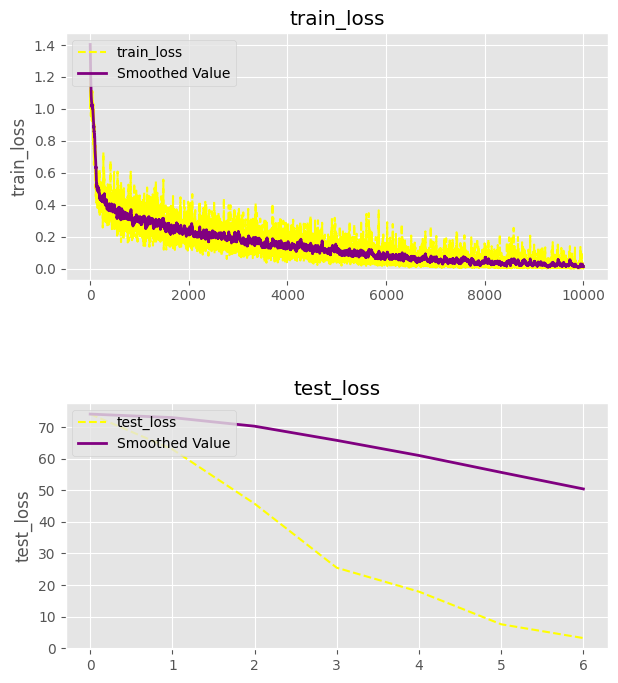

100%|██████████| 1250/1250 [02:22<00:00,  8.78it/s]


In [25]:
# Enable inline plotting
%matplotlib inline

# define optimizer, loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
# other hyperparameters
num_epochs = 10

train_loss_step = []
test_loss_epoch = []
plot_every = 100
step = 0

for epoch in range(num_epochs):
    
    # Training loop
    model.train()
    for batch in tqdm.tqdm(train_data_loader):
        states, actions = batch # states: List(str), actions: Tensor(batch_size, num_actions)
        
        actions = actions.to('cuda')
        
        # Forward pass
        q_values = model(states)
        
        # Compute loss
        loss = criterion(q_values, actions)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss_step.append(loss.item())
        step += 1
        
        # Plot loss
        if step % plot_every == 0:
            plot_data = {"train_loss": train_loss_step, "test_loss": test_loss_epoch}
            live_plot(plot_data)
    
    # Testing loop
    model.eval()
    epoch_test_loss = 0
    with torch.no_grad():
        for batch in test_data_loader:
            states, actions = batch
            actions = actions.to('cuda')
            
            # Forward pass
            q_values = model(states)
            
            # Compute loss
            loss = criterion(q_values, actions)
            
            epoch_test_loss += loss.item()
            
    # save model
    torch.save(model.state_dict(), f"models/elvator_dqn_lm_imitate_epoch_{epoch}.pt")
            
    # early stop if test loss is increasing
    if len(test_loss_epoch) > 0 and epoch_test_loss > test_loss_epoch[-1]:
        break
            
    test_loss_epoch.append(epoch_test_loss)
    


### Test NLPolicyNetwork (dagger) on environment

In [ ]:
best_model = 'elvator_dqn_lm_imitate_epoch_6.pt'
model_path = f"models/{best_model}"
model = NLPolicyNetwork(
    encoder_name='sentence-transformers/all-mpnet-base-v2',
    output_dim=4,
    num_transformer_layers=1,
    fc_hidden_dims=[512, 256],
    device='cuda'
)
model.load_state_dict(torch.load(model_path))

C:\Users\ianch\AppData\Local\Temp\ipykernel_24120\3334896167.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [12]:
def create_elevator_env():
    return ElevatorEnvironment()

NUM_ENVS = 8

env_vectorized = gym.vector.SyncVectorEnv([lambda: create_elevator_env() for _ in range(NUM_ENVS)])

c:\Users\ianch\miniconda3\envs\aiplanning\Lib\site-packages\pyRDDLGym\Examples c:\Users\ianch\miniconda3\envs\aiplanning\Lib\site-packages\pyRDDLGym\Examples\manifest.csv
Available example environment(s):
CartPole_continuous -> A simple continuous state-action MDP for the classical cart-pole system by Rich Sutton, with actions that describe the continuous force applied to the cart.
CartPole_discrete -> A simple continuous state MDP for the classical cart-pole system by Rich Sutton, with discrete actions that apply a constant force on either the left or right side of the cart.
Elevators -> The Elevator domain models evening rush hours when people from different floors in a building want to go down to the bottom floor using elevators.
HVAC -> Multi-zone and multi-heater HVAC control problem
MarsRover -> Multi Rover Navigation, where a group of agent needs to harvest mineral.
MountainCar -> A simple continuous MDP for the classical mountain car control problem.
NewLanguage -> Example with

c:\Users\ianch\miniconda3\envs\aiplanning\Lib\site-packages\pyRDDLGym\Core\Env\RDDLConstraints.py:85: UserWarning: Constraint does not have a structure of <action or state fluent> <op> <rhs>, where:
<op> is one of {<=, <, >=, >}
<rhs> is a deterministic function of non-fluents or constants only.
>> ( sum_{?f: floor} [ elevator-at-floor(?e, ?f) ] ) == 1
  warnings.warn(


c:\Users\ianch\miniconda3\envs\aiplanning\Lib\site-packages\pyRDDLGym\Examples c:\Users\ianch\miniconda3\envs\aiplanning\Lib\site-packages\pyRDDLGym\Examples\manifest.csv
Available example environment(s):
CartPole_continuous -> A simple continuous state-action MDP for the classical cart-pole system by Rich Sutton, with actions that describe the continuous force applied to the cart.
CartPole_discrete -> A simple continuous state MDP for the classical cart-pole system by Rich Sutton, with discrete actions that apply a constant force on either the left or right side of the cart.
Elevators -> The Elevator domain models evening rush hours when people from different floors in a building want to go down to the bottom floor using elevators.
HVAC -> Multi-zone and multi-heater HVAC control problem
MarsRover -> Multi Rover Navigation, where a group of agent needs to harvest mineral.
MountainCar -> A simple continuous MDP for the classical mountain car control problem.
NewLanguage -> Example with

In [22]:

test_episodes = 10

rewards_episodes = []

model.eval().to('cuda')

pbar = tqdm.tqdm(range(test_episodes))

for i in pbar:
    states, _ = env_vectorized.reset()

    done = np.zeros(NUM_ENVS, dtype=bool)
    
    rewards_steps = []

    while not all(done):
        states_text = ElevatorEnvironment.state_to_text_vectorized(states)
        states_text = [s for s in states_text]
        
        with torch.no_grad():
            q_values = model(states_text)
            
        actions = q_values.argmax(dim=1).cpu().numpy()
        
        next_states, rewards_batch, done, _, _ = env_vectorized.step(actions)
        
        states = next_states
        
        rewards_steps.append(rewards_batch)
        
        batch_average_reward = np.mean(rewards_steps)
        pbar.set_description(f"Episode {i+1}/{test_episodes} - Average reward: {batch_average_reward:.2f}")
        
    rewards_episodes.append(rewards_steps)      
        
        
        

Episode 10/10 - Average reward: -2.54: 100%|██████████| 10/10 [01:16<00:00,  7.68s/it]


Mean reward: -2.43


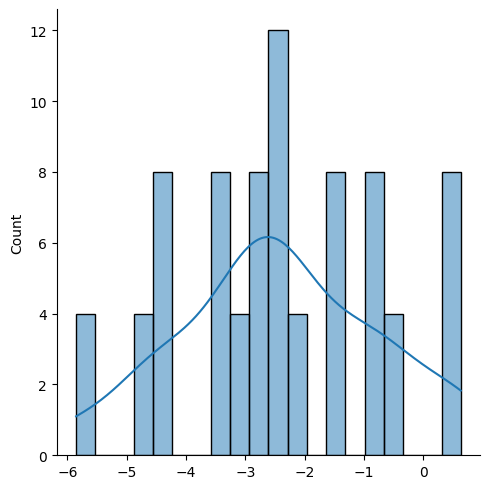

In [39]:
rewards_episodes = np.array(rewards_episodes)
# mean across steps per episode
rewards_episodes_mean = rewards_episodes.mean(axis=1)

# plot distribution of rewards, smoothed
import seaborn as sns

mean_flattened = rewards_episodes_mean.flatten()
print(f"Mean reward: {mean_flattened.mean():.2f}")
sns.displot(mean_flattened, kde=True, bins=20)

### Train NLPolicy - DQN Style

In [29]:
import torch
import torch.optim as optim
import random
import numpy as np
from collections import deque

# Hyperparameters
LEARNING_RATE = 1e-4

NUM_EPISODES = 2000

GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995

BATCH_SIZE = 128  

SAVE_INTERVAL = 100
UPDATE_INTERVAL = 1

#env params
min_reward = -52.5
max_reward = 300

In [ ]:
# Initialize DQN network and target network
policy_net = NLPolicyNetwork(
    encoder_name='sentence-transformers/all-mpnet-base-v2',
    output_dim=4,
    num_transformer_layers=1,
    fc_hidden_dims=[512, 256],
    device='cuda'
).to('cuda')
target_net = NLPolicyNetwork(
    encoder_name='sentence-transformers/all-mpnet-base-v2',
    output_dim=4,
    num_transformer_layers=1,
    fc_hidden_dims=[512, 256],
    device='cuda'
).to('cuda')
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()  # Target network is in eval mode to avoid unnecessary gradients

In [13]:
# Optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)

# Experience replay memory
replay_buffer = deque(maxlen=10000)  # Store up to 10000 recent experiences

# Epsilon-greedy policy
epsilon = EPSILON_START

In [6]:
# Setup vectorized environment
NUM_ENVS = 8

def create_elevator_env():
    return ElevatorEnvironment()

env_vectorized = gym.vector.SyncVectorEnv([lambda: create_elevator_env() for _ in range(NUM_ENVS)])

c:\Users\ianch\miniconda3\envs\aiplanning\Lib\site-packages\pyRDDLGym\Examples c:\Users\ianch\miniconda3\envs\aiplanning\Lib\site-packages\pyRDDLGym\Examples\manifest.csv
Available example environment(s):
CartPole_continuous -> A simple continuous state-action MDP for the classical cart-pole system by Rich Sutton, with actions that describe the continuous force applied to the cart.
CartPole_discrete -> A simple continuous state MDP for the classical cart-pole system by Rich Sutton, with discrete actions that apply a constant force on either the left or right side of the cart.
Elevators -> The Elevator domain models evening rush hours when people from different floors in a building want to go down to the bottom floor using elevators.
HVAC -> Multi-zone and multi-heater HVAC control problem
MarsRover -> Multi Rover Navigation, where a group of agent needs to harvest mineral.
MountainCar -> A simple continuous MDP for the classical mountain car control problem.
NewLanguage -> Example with

c:\Users\ianch\miniconda3\envs\aiplanning\Lib\site-packages\pyRDDLGym\Core\Env\RDDLConstraints.py:85: UserWarning: Constraint does not have a structure of <action or state fluent> <op> <rhs>, where:
<op> is one of {<=, <, >=, >}
<rhs> is a deterministic function of non-fluents or constants only.
>> ( sum_{?f: floor} [ elevator-at-floor(?e, ?f) ] ) == 1
  warnings.warn(


c:\Users\ianch\miniconda3\envs\aiplanning\Lib\site-packages\pyRDDLGym\Examples c:\Users\ianch\miniconda3\envs\aiplanning\Lib\site-packages\pyRDDLGym\Examples\manifest.csv
Available example environment(s):
CartPole_continuous -> A simple continuous state-action MDP for the classical cart-pole system by Rich Sutton, with actions that describe the continuous force applied to the cart.
CartPole_discrete -> A simple continuous state MDP for the classical cart-pole system by Rich Sutton, with discrete actions that apply a constant force on either the left or right side of the cart.
Elevators -> The Elevator domain models evening rush hours when people from different floors in a building want to go down to the bottom floor using elevators.
HVAC -> Multi-zone and multi-heater HVAC control problem
MarsRover -> Multi Rover Navigation, where a group of agent needs to harvest mineral.
MountainCar -> A simple continuous MDP for the classical mountain car control problem.
NewLanguage -> Example with

In [15]:
# Function to select actions in batch for a batch of states based on epsilon-greedy policy
action_space_n = 4

def select_actions(states_text, epsilon):
    if random.random() < epsilon:
        return [random.randint(0, action_space_n - 1) for _ in range(NUM_ENVS)]
    else:
        with torch.no_grad():            
            q_values = policy_net(states_text)
            
            actions = q_values.argmax(dim=1).cpu().numpy()
            
        return actions

In [32]:
CURRENT_EPISODE = 0 # keep track of current episode in case of interruption
#track some stats for live plot
total_losses = []
total_rewards = []

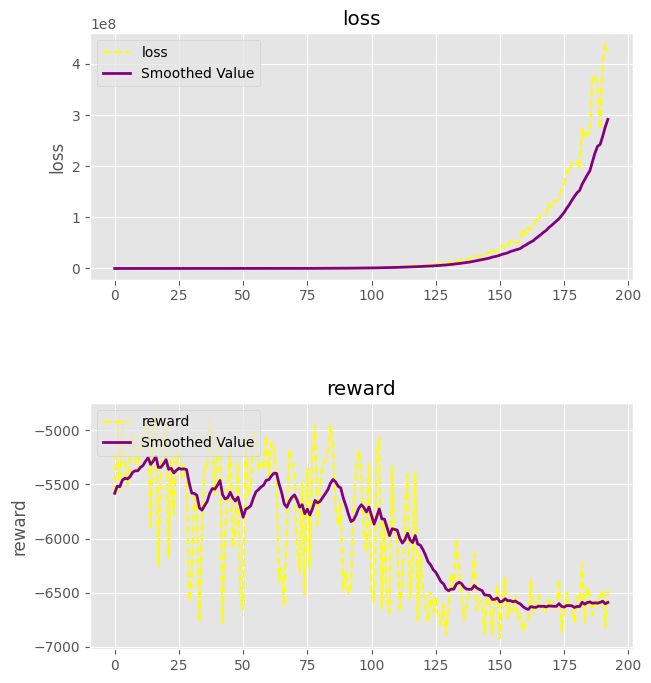

Episode 193/1000 - Step 200 - Epsilon 0.01 - Reward -6480.66:  19%|█▉        | 193/1000 [4:41:54<19:35:15, 87.38s/it]

In [ ]:
# Enable inline plotting
%matplotlib inline

# Training loop
num_episodes = 1000

pbar = tqdm.tqdm(range(num_episodes))

for episode in pbar:
    if episode < CURRENT_EPISODE:
        continue
    CURRENT_EPISODE = episode
    
    states, _ = env_vectorized.reset()
    states_text = ElevatorEnvironment.state_to_text_vectorized(states)
    states_text = [s for s in states_text]
    done_flags = np.zeros(NUM_ENVS, dtype=bool)
    episode_rewards = np.zeros(NUM_ENVS)
    episode_losses = []
    steps = 0

    while not any(done_flags):
        
        actions = select_actions(states_text, epsilon)

        # Take actions in the environment
        next_states, rewards, dones, _, _ = env_vectorized.step(actions)
        next_states_text = ElevatorEnvironment.state_to_text_vectorized(states)
        next_states_text = [s for s in states_text]

        # Store experiences in replay buffer
        replay_buffer.extend(zip(states_text, actions, rewards, next_states_text, dones))

        # Update episode rewards
        episode_rewards = episode_rewards + rewards
        # Update done flags
        done_flags = done_flags | dones

        states = next_states
        states_text = next_states_text

        # If replay buffer has enough samples, start training
        if len(replay_buffer) >= BATCH_SIZE:
            batch = random.sample(replay_buffer, BATCH_SIZE)
            states_batch, actions_batch, rewards_batch, next_states_batch, dones_batch = zip(*batch)

            states_batch = [s for s in states_batch]
            next_states_batch = [s for s in next_states_batch]
            actions_batch = torch.tensor(actions_batch, dtype=torch.long).unsqueeze(1).to('cuda')
            rewards_batch = torch.tensor(rewards_batch, dtype=torch.float32).to('cuda')
            dones_batch = torch.tensor(dones_batch, dtype=torch.float32).to('cuda')
                       
            q_values = policy_net(states_batch).gather(1, actions_batch).squeeze(1)

            with torch.no_grad():
                next_q_values = target_net(next_states_batch).max(1)[0]
                target_q_values = rewards_batch + GAMMA * next_q_values * (1 - dones_batch)

            loss = torch.nn.functional.mse_loss(q_values, target_q_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            episode_losses.append(loss.item())

        # Update epsilon
        epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)
        
        steps += 1
        
        pbar.set_description(f"Episode {episode+1}/{num_episodes} - Step {steps} - Epsilon {epsilon:.2f} - Reward {np.mean(episode_rewards):.2f}")

    # Update target network periodically
    if episode % UPDATE_INTERVAL == 0:
        target_net.load_state_dict(policy_net.state_dict())
        
    # Save model
    if episode % SAVE_INTERVAL == 0:
        torch.save(policy_net.state_dict(), f"weights/elevator_dqn_ep_{episode}.pt")
        
        
    # Update data for live plot
    total_losses.append(np.mean(episode_losses))
    total_rewards.append(np.mean(episode_rewards))
    
    plot_data = {"loss": total_losses, "reward": total_rewards}
    live_plot(plot_data)

    

Terminated the training because it seems to diverge. Hypothesis is that DQN is too unstable for the complexity of the task.

## NLP Actor Critic Network with PPO

PPO is supposed to have more stable training compared to DQN, let's test it out.

### Define ActorCritic Network

In [ ]:
from typing import List
from torch.distributions.categorical import Categorical

class NLActorCriticNetwork(nn.Module):
    def __init__(self, 
                 encoder_name='sentence-transformers/all-mpnet-base-v2',
                 action_space_n=4,
                 num_transformer_layers_shared=1,
                 num_transformer_layers_actor=1,
                 num_transformer_layers_critic=1,
                 fc_hidden_dims=[512, 256],
                 device='cuda'
                 ):
        super(NLActorCriticNetwork, self).__init__()
                
        self.tokenizer = AutoTokenizer.from_pretrained(encoder_name)
        self.encode_model = AutoModel.from_pretrained(encoder_name).to(device).eval()
        self.device = device   
        self.embedding_dim = self.encode_model.config.hidden_size
        
        transformer = nn.TransformerEncoderLayer(
            d_model=self.embedding_dim, nhead=8, dim_feedforward=2048
        )
        
        self.shared_encoder = nn.TransformerEncoder(transformer, num_layers=num_transformer_layers_shared)
        
        self.actor = TransformerNetwork(
            embedding_dim=self.embedding_dim,
            output_dim=action_space_n,
            num_transformer_layers=num_transformer_layers_actor,
            fc_hidden_dims=fc_hidden_dims
        ).to(device)
        
        self.critic = TransformerNetwork(           
            embedding_dim=self.embedding_dim,
            output_dim=1,
            num_transformer_layers=num_transformer_layers_critic,
            fc_hidden_dims=fc_hidden_dims
        ).to(device)
            
    def get_value(self, states: List[str]):
        """Calculate the estimated value for a given state.

        Args:
            states (List[str]): List of states as strings, shape: [batch_size]

        Returns:
            torch.Tensor: Estimated value for the state, shape: (batch_size, 1)
        """
        
        shared_embeddings = self.get_shared_embeddings(states)
        
        value = self.critic(shared_embeddings)
        
        return value
    
    def get_probs(self, states: List[str]):
        """Calculate the action probabilities for a given state.

        Args:
            states (List[str]): List of states as strings, shape: [batch_size]

        Returns:
            torch.distributions.Categorical: Categorical distribution over actions
        """
        
        shared_embeddings = self.get_shared_embeddings(states)
        
        logits = self.actor(shared_embeddings)
        probs = 
        
        
            
    def tokenize_states(self, states: List[str]):
        """ Tokenize list of states (str) and return as dictionary of tensors 
        Args:
            states (List[str]): List of states as strings, shape: [batch_size]
            
        Returns:
            states_tokenized (Dict[str, torch.Tensor]): Dictionary of tokenized states as tensors
        """
                
        states_tokenized = self.tokenizer(list(states), padding=True, truncation=True, return_tensors="pt")
        states_tokenized = {k: v.to(self.device) for k, v in states_tokenized.items()}
        
        return states_tokenized
    
    def get_shared_embeddings
        
        
        
        